<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/multi_class_U_Net_Model_(11_march_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# multi-class u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 63.0 MB/s eta 0:00:00


In [4]:
import rasterio

In [5]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio
import tensorflow as tf
from tensorflow.keras.models import load_model

In [6]:
from sklearn.model_selection import train_test_split
import shutil

OneYear data loading

In [7]:
directory_path = "/content/drive/MyDrive/data/images/x_training_140/3year_140"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 135 files in /content/drive/MyDrive/data/images/x_training_140/3year_140.


In [8]:
directory_path = "/content/drive/MyDrive/data/labels/y_training_140"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 135 files in /content/drive/MyDrive/data/labels/y_training_140.


In [ ]:
# there are 150 tiles total after the edits
# 10 are reserved for testing
# qi said 70 training, 20 validation, 10 for test
# 10% of 150 is 15. need 5 more
# 70% of 150 is 105, 30 for validation

In [9]:
x_training_01 = sorted(glob.glob(f"/content/drive/MyDrive/data/images/x_training_140/1year_140/*.tif"))
y_training = sorted(glob.glob(f"/content/drive/MyDrive/data/labels/y_training_140/*.tif"))

In [10]:
x_training_02 = sorted(glob.glob(f"/content/drive/MyDrive/data/images/x_training_140/2year_140/*.tif"))
# y_training = sorted(glob.glob(f"/content/drive/MyDrive/data/labels/y_training_140/*.tif"))

In [11]:
x_training_03 = sorted(glob.glob(f"/content/drive/MyDrive/data/images/x_training_140/3year_140/*.tif"))
# y_training = sorted(glob.glob(f"/content/drive/MyDrive/data/labels/y_training_140/*.tif"))

In [12]:
x_train_01, x_test_01, y_train, y_test = train_test_split(x_training_01, y_training, test_size=0.22, random_state=9)

In [13]:
x_test_01

['/content/drive/MyDrive/data/images/x_training_140/1year_140/1465_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/1561_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/172_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/127_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/1521_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/821_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/1563_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/1481_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/842_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/188_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/189_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_140/1578_1year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/1year_

In [14]:
x_train_02, x_test_02, y_train, y_test = train_test_split(x_training_02, y_training, test_size=0.22, random_state=9)

In [15]:
x_test_02

['/content/drive/MyDrive/data/images/x_training_140/2year_140/1465_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/1561_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/172_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/127_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/1521_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/821_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/1563_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/1481_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/842_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/188_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/189_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_140/1578_2year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/2year_

In [16]:
x_train_03, x_test_03, y_train, y_test = train_test_split(x_training_03, y_training, test_size=0.22, random_state=9)

In [18]:
y_test

['/content/drive/MyDrive/data/labels/y_training_140/1465_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/1561_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/172_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/127_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/1521_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/821_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/1563_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/1481_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/842_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/188_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/189_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/1578_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/330_multi_wl.tif',
 '/content/drive/MyDrive/data/labels/y_training_140/762_multi_wl.tif',


In [17]:
x_test_03

['/content/drive/MyDrive/data/images/x_training_140/3year_140/1465_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/1561_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/172_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/127_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/1521_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/821_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/1563_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/1481_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/842_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/188_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/189_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_140/1578_3year.tif',
 '/content/drive/MyDrive/data/images/x_training_140/3year_

In [ ]:
# Ensure the lists are sorted so that images and labels correspond to each other
x_training = sorted(glob.glob(f"/content/drive/MyDrive/data/images/x_training_140/3year_140/*.tif"))
y_training = sorted(glob.glob(f"/content/drive/MyDrive/data/labels/y_training_140/*.tif"))

# Split the file paths into training and testing sets (70% train, 20% test, 10% but that's already accounted for. so keep 0.2!)
x_train, x_test, y_train, y_test = train_test_split(x_training, y_training, test_size=0.22, random_state=9)

In [ ]:
# N = 50
# nu = 5

# random_train_indices = np.random.choice(len(x_train), N, replace=False)
# random_test_indices = np.random.choice(len(x_test), nu, replace=False)

# # Subset the data using these random indices
# subset_x_train = [x_train[i] for i in random_train_indices]
# subset_y_train = [y_train[i] for i in random_train_indices]
# subset_x_test = [x_test[i] for i in random_test_indices]
# subset_y_test = [y_test[i] for i in random_test_indices]

In [19]:
destination = '/content/y_test'
os.makedirs(destination, exist_ok=True)
for file in y_test:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/y_test"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/labels/y_training_140/1465_multi_wl.tif to /content/y_test/1465_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/1561_multi_wl.tif to /content/y_test/1561_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/172_multi_wl.tif to /content/y_test/172_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/127_multi_wl.tif to /content/y_test/127_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/1521_multi_wl.tif to /content/y_test/1521_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/821_multi_wl.tif to /content/y_test/821_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/1563_multi_wl.tif to /content/y_test/1563_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/1481_multi_wl.tif to /content/y_test/1481_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/842_multi_wl.tif to /content/y_test/842_multi_wl.tif


In [20]:
destination = '/content/y_train'
os.makedirs(destination, exist_ok=True)
for file in y_train:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/y_train"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/labels/y_training_140/797_multi_wl.tif to /content/y_train/797_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/142_multi_wl.tif to /content/y_train/142_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/170_multi_wl.tif to /content/y_train/170_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/221_multi_wl.tif to /content/y_train/221_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/778_multi_wl.tif to /content/y_train/778_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/795_multi_wl.tif to /content/y_train/795_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/1580_multi_wl.tif to /content/y_train/1580_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/1529_multi_wl.tif to /content/y_train/1529_multi_wl.tif
Copied /content/drive/MyDrive/data/labels/y_training_140/143_multi_wl.tif to /content/y_train/143_multi_wl.t

In [21]:
destination = '/content/x_test_01'
os.makedirs(destination, exist_ok=True)
for file in x_test_01:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_test_01"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1465_1year.tif to /content/x_test_01/1465_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1561_1year.tif to /content/x_test_01/1561_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/172_1year.tif to /content/x_test_01/172_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/127_1year.tif to /content/x_test_01/127_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1521_1year.tif to /content/x_test_01/1521_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/821_1year.tif to /content/x_test_01/821_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1563_1year.tif to /content/x_test_01/1563_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1481_1year.tif to /content/x_test_01/1481_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_1

In [22]:
destination = '/content/x_train_01'
os.makedirs(destination, exist_ok=True)
for file in x_train_01:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_train_01"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/797_1year.tif to /content/x_train_01/797_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/142_1year.tif to /content/x_train_01/142_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/170_1year.tif to /content/x_train_01/170_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/221_1year.tif to /content/x_train_01/221_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/778_1year.tif to /content/x_train_01/778_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/795_1year.tif to /content/x_train_01/795_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1580_1year.tif to /content/x_train_01/1580_1year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/1year_140/1529_1year.tif to /content/x_train_01/1529_1year.tif
Copied /content/drive/MyDrive/data/images/x_training

In [23]:
destination = '/content/x_test_02'
os.makedirs(destination, exist_ok=True)
for file in x_test_02:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_test_02"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1465_2year.tif to /content/x_test_02/1465_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1561_2year.tif to /content/x_test_02/1561_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/172_2year.tif to /content/x_test_02/172_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/127_2year.tif to /content/x_test_02/127_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1521_2year.tif to /content/x_test_02/1521_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/821_2year.tif to /content/x_test_02/821_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1563_2year.tif to /content/x_test_02/1563_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1481_2year.tif to /content/x_test_02/1481_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_1

In [24]:
destination = '/content/x_train_02'
os.makedirs(destination, exist_ok=True)
for file in x_train_02:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_train_02"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/797_2year.tif to /content/x_train_02/797_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/142_2year.tif to /content/x_train_02/142_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/170_2year.tif to /content/x_train_02/170_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/221_2year.tif to /content/x_train_02/221_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/778_2year.tif to /content/x_train_02/778_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/795_2year.tif to /content/x_train_02/795_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1580_2year.tif to /content/x_train_02/1580_2year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/2year_140/1529_2year.tif to /content/x_train_02/1529_2year.tif
Copied /content/drive/MyDrive/data/images/x_training

In [25]:
destination = '/content/x_test_03'
os.makedirs(destination, exist_ok=True)
for file in x_test_03:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_test_03"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1465_3year.tif to /content/x_test_03/1465_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1561_3year.tif to /content/x_test_03/1561_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/172_3year.tif to /content/x_test_03/172_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/127_3year.tif to /content/x_test_03/127_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1521_3year.tif to /content/x_test_03/1521_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/821_3year.tif to /content/x_test_03/821_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1563_3year.tif to /content/x_test_03/1563_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1481_3year.tif to /content/x_test_03/1481_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_1

In [26]:
destination = '/content/x_train_03'
os.makedirs(destination, exist_ok=True)
for file in x_train_03:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')
directory_path = "/content/x_train_03"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/797_3year.tif to /content/x_train_03/797_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/142_3year.tif to /content/x_train_03/142_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/170_3year.tif to /content/x_train_03/170_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/221_3year.tif to /content/x_train_03/221_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/778_3year.tif to /content/x_train_03/778_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/795_3year.tif to /content/x_train_03/795_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1580_3year.tif to /content/x_train_03/1580_3year.tif
Copied /content/drive/MyDrive/data/images/x_training_140/3year_140/1529_3year.tif to /content/x_train_03/1529_3year.tif
Copied /content/drive/MyDrive/data/images/x_training

In [27]:
x_train_01 = sorted(glob.glob(f"/content/x_train_01/*.tif"))
x_test_01 = sorted(glob.glob(f"/content/x_test_01/*.tif"))

x_train_02 = sorted(glob.glob(f"/content/x_train_02/*.tif"))
x_test_02 = sorted(glob.glob(f"/content/x_test_02/*.tif"))

x_train_03 = sorted(glob.glob(f"/content/x_train_03/*.tif"))
x_test_03 = sorted(glob.glob(f"/content/x_test_03/*.tif"))

y_train = sorted(glob.glob(f"/content/y_train/*.tif"))
y_test= sorted(glob.glob(f"/content/y_test/*.tif"))

# three_x_train = sorted(glob.glob(f"/content/x_train_three/*.tif"))
# y_train = sorted(glob.glob(f"/content/y_train_three/*.tif"))

# three_x_test = sorted(glob.glob(f"/content/x_test_three/*.tif"))
# y_test= sorted(glob.glob(f"/content/y_test_three/*.tif"))

In [28]:
print(f"there are {len(x_train_01)} images for training")
print(f"there are {len(x_train_02)} images for training")
print(f"there are {len(x_train_03)} images for training")
print(f"there are {len(x_test_01)} images for validation")
print(f"there are {len(x_test_02)} images for validation")
print(f"there are {len(x_test_03)} images for validation")

print(f"there are {len(y_train)} labels for training")
print(f"there are {len(y_test)} labels for validation")

there are 105 images for training
there are 105 images for training
there are 105 images for training
there are 30 images for validation
there are 30 images for validation
there are 30 images for validation
there are 105 labels for training
there are 30 labels for validation


same from here

In [ ]:
# # for 1 year images - this works dont f it up
# def read_multi_image(file_path):
#     with rasterio.open(file_path) as src:
#       bands = [src.read(i) for i in range(1,5)]

#       image = np.stack(bands, axis=-1)

#       image = image.astype(float)
#       max_value = image.max(axis=(0,1), keepdims=True)
#       min_value = image.min(axis=(0,1), keepdims=True)
#       image = (image - min_value) / (max_value - min_value)

#       return image

In [29]:
# for 1 year images - this with handling of band 5
def read_multi_image_withfive(file_path):
    with rasterio.open(file_path) as src:
      bands = [src.read(i) for i in range(1,5)]

      image = np.stack(bands, axis=-1)

      image = image.astype(float)
      max_value = image.max(axis=(0,1), keepdims=True)
      min_value = image.min(axis=(0,1), keepdims=True)
      image = (image - min_value) / (max_value - min_value)

      band_five = src.read(5)

      band_five = band_five.astype(float) /band_five.max()
      band_five = np.expand_dims(band_five, axis=-1)
      combined_image = np.concatenate([image, band_five], axis=-1)


      return combined_image

In [30]:
# for 1 year images - this with handling of band 5
def read_nine_band_image(file_path):
    with rasterio.open(file_path) as src:
      bands = [src.read(i) for i in range(1,9)]

      image = np.stack(bands, axis=-1)

      image = image.astype(float)
      max_value = image.max(axis=(0,1), keepdims=True)
      min_value = image.min(axis=(0,1), keepdims=True)
      image = (image - min_value) / (max_value - min_value)

      band_five = src.read(9)

      band_five = band_five.astype(float) /band_five.max()
      band_five = np.expand_dims(band_five, axis=-1)
      combined_image = np.concatenate([image, band_five], axis=-1)


      return combined_image

In [31]:
# for 1 year images - this with handling of band 5
def read_thirteen_band_image(file_path):
    with rasterio.open(file_path) as src:
      bands = [src.read(i) for i in range(1,13)]

      image = np.stack(bands, axis=-1)

      image = image.astype(float)
      max_value = image.max(axis=(0,1), keepdims=True)
      min_value = image.min(axis=(0,1), keepdims=True)
      image = (image - min_value) / (max_value - min_value)

      band_five = src.read(13)

      band_five = band_five.astype(float) /band_five.max()
      band_five = np.expand_dims(band_five, axis=-1)
      combined_image = np.concatenate([image, band_five], axis=-1)


      return combined_image

In [ ]:
# def preprocess_data(image_path):
#     with rasterio.open(image_path) as src:
#         # Read the first four bands, assuming we drop the fifth band
#         image = src.read([1, 2, 3, 4])  # Adjust the indices based on which bands you need
#         image = np.transpose(image, (1, 2, 0))  # Reorder dimensions to (height, width, channels)
#     return image

# # Then use this function to load your images:
# x_train = np.array([preprocess_data(path) for path in train_paths])
# x_test = np.array([preprocess_data(path) for path in test_paths])


In [ ]:
# pre_x_train = np.array([preprocess_data(path) for path in subset_x_train])

In [32]:
def read_image_labels(file_path):
    with rasterio.open(file_path) as src:
      label_image = src.read(1) # read the sing band
      return label_image.astype(np.int32) # ensuring labels are interger type

In [ ]:
# lets read and process image data for the subsets using read_multi_image to convert
# each path in the subset into useable data array for x and y data

# one_x_train_data = [read_multi_image_withfive(file_path) for file_path in one_x_train]
# one_x_test_data = [read_multi_image_withfive(file_path) for file_path in one_x_test]
# y_train_data = [read_image_labels(file_path) for file_path in y_train]
# y_test_data = [read_image_labels(file_path) for file_path in y_test]
# print(type(one_x_train_data))
# print(type(y_train_data))

<class 'list'>
<class 'list'>


In [ ]:
# one_x_train_data[77]  # 0.10719041, 0.12836439, 0.11988365, 0.60480434, 0.36336157 3
                      # 0.06685982, 0.09896104, 0.07385445, 0.39563863, 0.21425932 7
                      # 0.09306261, 0.11989796, 0.07724601, 0.68828829, 0.49641504 77

In [ ]:
# two_x_train_data = [read_nine_band_image(file_path) for file_path in two_x_train]
# two_x_test_data = [read_nine_band_image(file_path) for file_path in two_x_test]
# y_train_data = [read_image_labels(file_path) for file_path in y_train]
# y_test_data = [read_image_labels(file_path) for file_path in y_test]

In [ ]:
# print(f"there are {len(x_train_01)} images for training")
# print(f"there are {len(x_train_02)} images for training")
# print(f"there are {len(x_train_03)} images for training")
# print(f"there are {len(x_test_01)} images for validation")
# print(f"there are {len(x_test_02)} images for validation")
# print(f"there are {len(x_test_03)} images for validation")

# print(f"there are {len(y_train)} labels for training")
# print(f"there are {len(y_test)} labels for validation")

In [33]:
x_train_01_data = [read_multi_image_withfive(file_path) for file_path in x_train_01]
x_test_01_data = [read_multi_image_withfive(file_path) for file_path in x_test_01]


x_train_02_data = [read_nine_band_image(file_path) for file_path in x_train_02]
x_test_02_data = [read_nine_band_image(file_path) for file_path in x_test_02]



x_train_03_data = [read_thirteen_band_image(file_path) for file_path in x_train_03]
x_test_03_data = [read_thirteen_band_image(file_path) for file_path in x_test_03]



y_train_data = [read_image_labels(file_path) for file_path in y_train]
y_test_data = [read_image_labels(file_path) for file_path in y_test]
# three_x_train_data[3] # 0.06685982, 0.09896104, 0.07385445, 0.39563863, 0.21425932

In [ ]:
# one_x_train_data[4]

In [ ]:
# # Example: Check the first element to see its unique values and shape
print("Unique labels y_train image:", np.unique(y_train_data[77])) # 77: [1 2 4 5 6 7]
print("Shape of y_train image:", y_test_data[8].shape) # (384, 384)
print("Shape of x_train image:", three_x_train_data[8].shape) # (384, 384, 13)


Unique labels y_train image: [1 2 4 5 6 7]
Shape of y_train image: (384, 384)
Shape of x_train image: (384, 384, 13)


In [35]:
x_train_01 = np.array(x_train_01_data)
x_test_01 = np.array(x_test_01_data)

x_train_02 = np.array(x_train_02_data)
x_test_02 = np.array(x_test_02_data)

x_train_03 = np.array(x_train_03_data)
x_test_03 = np.array(x_test_03_data)


y_train = np.array(y_train_data)
y_test = np.array(y_test_data)

print(type(x_train_01))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [36]:
print(x_train_01.shape)
print(x_test_01.shape)

print(x_train_02.shape)
print(x_test_02.shape)

print(x_train_03.shape)
print(x_test_03.shape)

print(y_train.shape)
print(y_test.shape)

(105, 384, 384, 5)
(30, 384, 384, 5)
(105, 384, 384, 9)
(30, 384, 384, 9)
(105, 384, 384, 13)
(30, 384, 384, 13)
(105, 384, 384)
(30, 384, 384)


In [40]:
from tensorflow.keras.utils import to_categorical

In [37]:
y_train_shifted = y_train -1
y_test_shifted = y_test -1

In [38]:
print(y_train_shifted.shape)
print(y_test_shifted.shape)

(105, 384, 384)
(30, 384, 384)


In [41]:
y_train_encoded = to_categorical(y_train_shifted, num_classes = 7)
y_test_encoded = to_categorical(y_test_shifted, num_classes = 7)

In [42]:
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(105, 384, 384, 7)
(30, 384, 384, 7)


In [ ]:
# print(three_x_train.shape)
# print(three_x_test.shape)

(105, 384, 384, 13)
(30, 384, 384, 13)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet_model(input_size=(384, 384, 13), num_classes=7):
    inputs = Input(input_size)

    # Downsampling (Contracting Path)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)

    # Upsampling (Expanding Path)
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
model = unet_model()


In [ ]:
print(model.input)
print(model.output)


KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 13), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 7), dtype=tf.float32, name=None), name='conv2d_21/Softmax:0', description="created by layer 'conv2d_21'")


In [ ]:
print(model.summary()) # oneYear = 1889799  twoyear 1892103  threeyear 1894407

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 384, 384, 13)]       0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 384, 384, 64)         7552      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 384, 384, 64)         256       ['conv2d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_5 (Dropout)         (None, 384, 384, 64)         0         ['batch_normalization_10

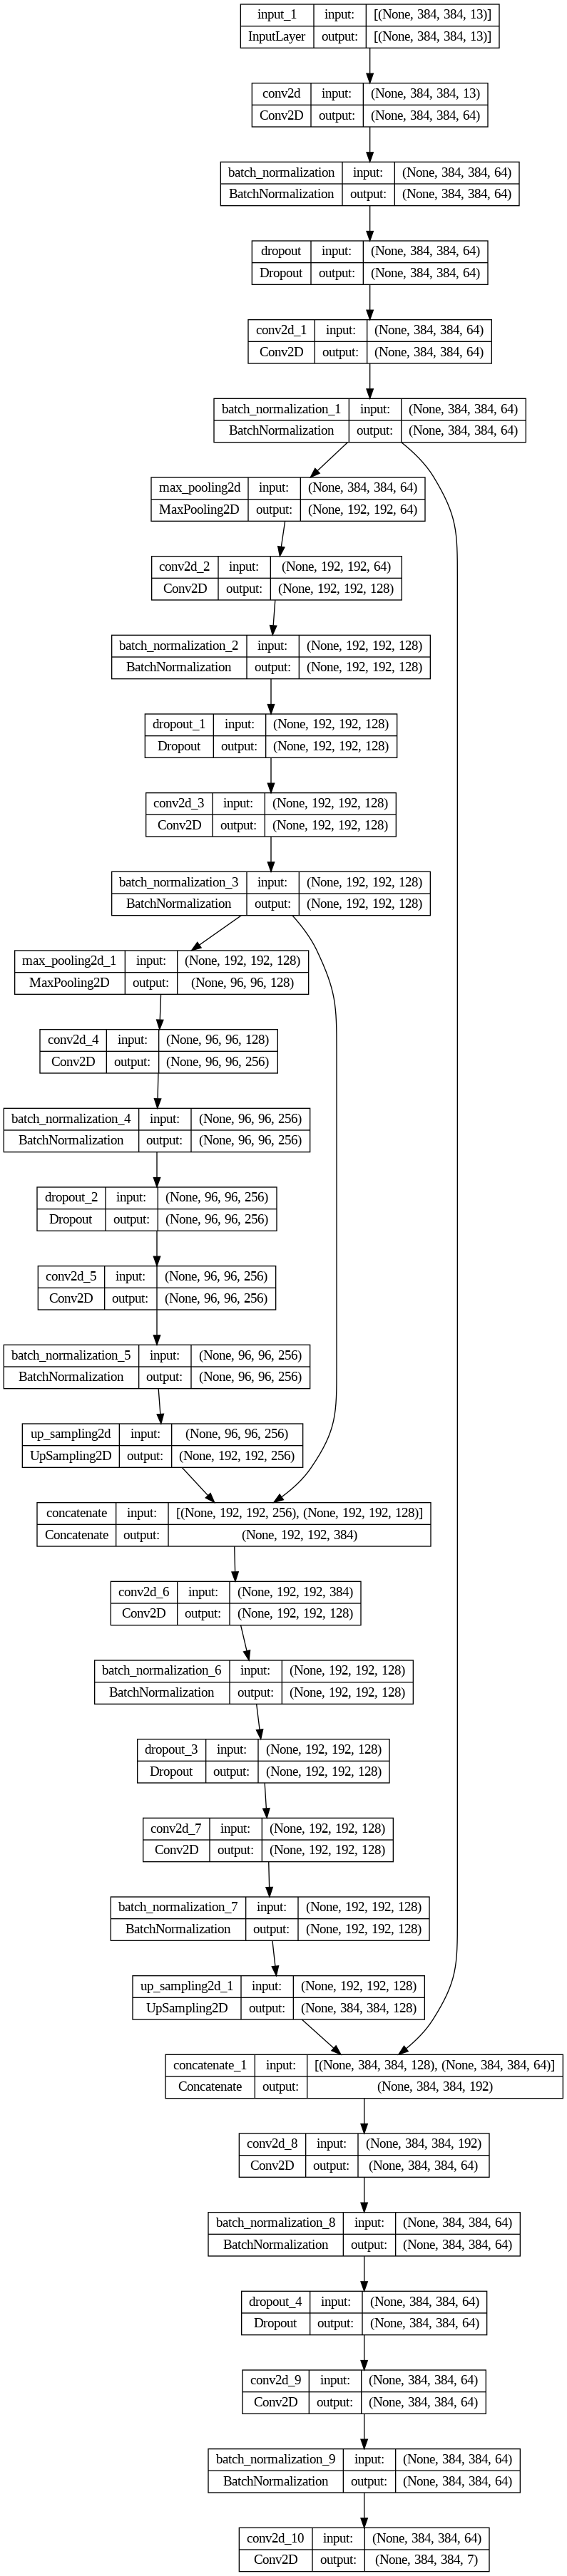

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="/content/drive/MyDrive/data/model_prediction/threeyear_data/model_plot_threeyear_20240418_1448.png", show_shapes=True, show_layer_names=True)

In [ ]:
from IPython.display import Image

# Display the image in Jupyter notebook
# Image(filename='model_plot_oneyears.png')

# Compile, fit and predict on test_dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
import shutil
import zipfile

In [ ]:
# def read_multi_image_withfive(file_path):
#     with rasterio.open(file_path) as src:
#       bands = [src.read(i) for i in range(1,5)]
#       image = np.stack(bands, axis=-1)
#       image = image.astype(float)
#       max_value = image.max(axis=(0,1), keepdims=True)
#       min_value = image.min(axis=(0,1), keepdims=True)
#       image = (image - min_value) / (max_value - min_value)
#       band_five = src.read(5)
#       band_five = band_five.astype(float) /band_five.max()
#       band_five = np.expand_dims(band_five, axis=-1)
#       combined_image = np.concatenate([image, band_five], axis=-1)
#       return combined_image

In [ ]:
class SavePredictionCallback(Callback):
    def __init__(self, x_holdout_dir, output_folder, model_input_size, epoch_frequency=5):
        self.x_holdout_dir = glob.glob(x_holdout_dir)  # Get all file paths matching the pattern
        self.output_folder = output_folder
        self.model_input_size = model_input_size
        self.epoch_frequency = epoch_frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.x_holdout_dir:
                # Read the image with rasterio
                with rasterio.open(image_path) as src:
                    bands = [src.read(i) for i in range(1, 13)]
                    image = np.stack(bands, axis=-1)
                    image = image.astype(float)
                    max_value = image.max(axis=(0, 1), keepdims=True)
                    min_value = image.min(axis=(0, 1), keepdims=True)
                    image = (image - min_value) / (max_value - min_value)
                    band_five = src.read(13)
                    band_five = band_five.astype(float) / band_five.max()
                    band_five = np.expand_dims(band_five, axis=-1)
                    combined_image = np.concatenate([image, band_five], axis=-1)
                    combined_image_batch = np.expand_dims(combined_image, axis=0)
                    # image = src.read()  # Read all bands
                    # image = np.transpose(image, (1, 2, 0))  # Reorder dimensions to (height, width, channels)
                    # image = np.expand_dims(image, axis=-1)  # Add batch dimension
                    # image = image.astype(np.float32) / 255.0  # Normalize the image if needed

                # Predict using the model
                prediction = self.model.predict(combined_image_batch)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]# Get the predicted class for each pixel

                # Prepare the output path
                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")

                # Save the prediction using rasterio
                meta = src.meta.copy()
                meta.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata= None)  # Set metadata for output
                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# Initialization of the callback
img_height, img_width = 384, 384
output_folder = "/content/drive/MyDrive/data/model_prediction/threeyear_data/20240418_1448"
os.makedirs(output_folder, exist_ok=True)  # Ensure the output directory exists
x_holdout_dir = "/content/drive/MyDrive/data/images/x_test/3year/*.tif"

savepred_callback = SavePredictionCallback(
    x_holdout_dir=x_holdout_dir,
    output_folder=output_folder,
    model_input_size = (img_height, img_width),
    epoch_frequency=5
)


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy', 'categorical_accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = "/content/drive/MyDrive/data/model_prediction/threeyear_data/20240418_1448/20240418_1448_3.h5", monitor = 'val_loss', save_best_only = True), savepred_callback]

In [ ]:
history_03 = model.fit(three_x_train, y_train_encoded, batch_size=8, epochs=500, validation_data=(three_x_test, y_test_encoded),
          callbacks=[callbacks])

Epoch 1/500
 6/14 [===========>..................] - ETA: 8s - loss: 2.3126 - accuracy: 0.2614 - categorical_accuracy: 0.2614

14/14 [==============================] - ETA: 0s - loss: 2.1051 - accuracy: 0.3535 - categorical_accuracy: 0.3535

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 41s 3s/step - loss: 2.1051 - accuracy: 0.3535 - categorical_accuracy: 0.3535 - val_loss: 10.2306 - val_accuracy: 0.1090 - val_categorical_accuracy: 0.1090
Epoch 2/500
14/14 [==============================] - 12s 866ms/step - loss: 1.7290 - accuracy: 0.5136 - categorical_accuracy: 0.5136 - val_loss: 10.6494 - val_accuracy: 0.0768 - val_categorical_accuracy: 0.0768
Epoch 3/500
14/14 [==============================] - ETA: 0s - loss: 1.6061 - accuracy: 0.5908 - categorical_accuracy: 0.5908

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 14s 1s/step - loss: 1.6061 - accuracy: 0.5908 - categorical_accuracy: 0.5908 - val_loss: 2.3439 - val_accuracy: 0.4199 - val_categorical_accuracy: 0.4199
Epoch 4/500
14/14 [==============================] - 12s 911ms/step - loss: 1.4584 - accuracy: 0.6365 - categorical_accuracy: 0.6365 - val_loss: 3.4394 - val_accuracy: 0.2258 - val_categorical_accuracy: 0.2258
Epoch 5/500
14/14 [==============================] - 11s 791ms/step - loss: 1.3878 - accuracy: 0.6483 - categorical_accuracy: 0.6483 - val_loss: 3.2742 - val_accuracy: 0.3518 - val_categorical_accuracy: 0.3518
Epoch 6/500
14/14 [==============================] - 18s 1s/step - loss: 1.3075 - accuracy: 0.6634 - categorical_accuracy: 0.6634 - val_loss: 2.7857 - val_accuracy: 0.2300 - val_categorical_accuracy: 0.2300
Epoch 7/500
14/14 [==============================] - 14s 1s/step - loss: 1.2361 - accuracy: 0.6577 - categorical_accuracy: 0.6577 - val_loss: 2.2866 - val_accuracy: 0.3819 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/500
14/14 [==============================] - 12s 911ms/step - loss: 1.2159 - accuracy: 0.6837 - categorical_accuracy: 0.6837 - val_loss: 3.8615 - val_accuracy: 0.2239 - val_categorical_accuracy: 0.2239
Epoch 9/500
14/14 [==============================] - 12s 865ms/step - loss: 1.1294 - accuracy: 0.7131 - categorical_accuracy: 0.7131 - val_loss: 3.9603 - val_accuracy: 0.2559 - val_categorical_accuracy: 0.2559
Epoch 10/500
14/14 [==============================] - ETA: 0s - loss: 1.1302 - accuracy: 0.6835 - categorical_accuracy: 0.6835

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 11s 816ms/step - loss: 1.1302 - accuracy: 0.6835 - categorical_accuracy: 0.6835 - val_loss: 1.3431 - val_accuracy: 0.6538 - val_categorical_accuracy: 0.6538
Epoch 11/500
14/14 [==============================] - ETA: 0s - loss: 1.1497 - accuracy: 0.6820 - categorical_accuracy: 0.6820

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 18s 1s/step - loss: 1.1497 - accuracy: 0.6820 - categorical_accuracy: 0.6820 - val_loss: 1.0228 - val_accuracy: 0.6384 - val_categorical_accuracy: 0.6384
Epoch 12/500
14/14 [==============================] - 11s 802ms/step - loss: 1.0594 - accuracy: 0.6955 - categorical_accuracy: 0.6955 - val_loss: 1.1127 - val_accuracy: 0.6623 - val_categorical_accuracy: 0.6623
Epoch 13/500
14/14 [==============================] - 13s 934ms/step - loss: 0.9953 - accuracy: 0.7038 - categorical_accuracy: 0.7038 - val_loss: 1.0088 - val_accuracy: 0.7170 - val_categorical_accuracy: 0.7170
Epoch 14/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 13s 984ms/step - loss: 0.9883 - accuracy: 0.7055 - categorical_accuracy: 0.7055 - val_loss: 0.9553 - val_accuracy: 0.7159 - val_categorical_accuracy: 0.7159
Epoch 15/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 12s 874ms/step - loss: 0.9334 - accuracy: 0.7176 - categorical_accuracy: 0.7176 - val_loss: 0.9295 - val_accuracy: 0.7284 - val_categorical_accuracy: 0.7284
Epoch 16/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.7287 - categorical_accuracy: 0.7287

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 22s 2s/step - loss: 0.8911 - accuracy: 0.7287 - categorical_accuracy: 0.7287 - val_loss: 0.9187 - val_accuracy: 0.7014 - val_categorical_accuracy: 0.7014
Epoch 17/500
14/14 [==============================] - 14s 1s/step - loss: 0.8883 - accuracy: 0.7328 - categorical_accuracy: 0.7328 - val_loss: 0.9711 - val_accuracy: 0.6857 - val_categorical_accuracy: 0.6857
Epoch 18/500
14/14 [==============================] - 11s 803ms/step - loss: 0.9045 - accuracy: 0.7218 - categorical_accuracy: 0.7218 - val_loss: 1.0461 - val_accuracy: 0.6630 - val_categorical_accuracy: 0.6630
Epoch 19/500
14/14 [==============================] - 10s 751ms/step - loss: 0.9080 - accuracy: 0.7166 - categorical_accuracy: 0.7166 - val_loss: 0.9779 - val_accuracy: 0.6747 - val_categorical_accuracy: 0.6747
Epoch 20/500
14/14 [==============================] - 13s 967ms/step - loss: 0.8662 - accuracy: 0.7279 - categorical_accuracy: 0.7279 - val_loss: 0.9112 - val_accuracy: 0.7387

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 17s 1s/step - loss: 0.8507 - accuracy: 0.7362 - categorical_accuracy: 0.7362 - val_loss: 0.9327 - val_accuracy: 0.6786 - val_categorical_accuracy: 0.6786
Epoch 22/500
14/14 [==============================] - 13s 984ms/step - loss: 0.8393 - accuracy: 0.7427 - categorical_accuracy: 0.7427 - val_loss: 0.9980 - val_accuracy: 0.6405 - val_categorical_accuracy: 0.6405
Epoch 23/500
14/14 [==============================] - 14s 1s/step - loss: 0.8981 - accuracy: 0.7012 - categorical_accuracy: 0.7012 - val_loss: 0.9215 - val_accuracy: 0.7029 - val_categorical_accuracy: 0.7029
Epoch 24/500
14/14 [==============================] - 12s 862ms/step - loss: 0.8571 - accuracy: 0.7306 - categorical_accuracy: 0.7306 - val_loss: 0.9600 - val_accuracy: 0.6778 - val_categorical_accuracy: 0.6778
Epoch 25/500
14/14 [==============================] - 13s 927ms/step - loss: 0.7962 - accuracy: 0.7537 - categorical_accuracy: 0.7537 - val_loss: 0.8438 - val_accuracy: 0.7385

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 26/500
14/14 [==============================] - 18s 1s/step - loss: 0.7842 - accuracy: 0.7554 - categorical_accuracy: 0.7554 - val_loss: 1.0008 - val_accuracy: 0.6491 - val_categorical_accuracy: 0.6491
Epoch 27/500
14/14 [==============================] - 13s 928ms/step - loss: 0.7750 - accuracy: 0.7535 - categorical_accuracy: 0.7535 - val_loss: 0.8741 - val_accuracy: 0.7120 - val_categorical_accuracy: 0.7120
Epoch 28/500
14/14 [==============================] - ETA: 0s - loss: 0.8017 - accuracy: 0.7454 - categorical_accuracy: 0.7454

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 13s 926ms/step - loss: 0.8017 - accuracy: 0.7454 - categorical_accuracy: 0.7454 - val_loss: 0.8124 - val_accuracy: 0.7248 - val_categorical_accuracy: 0.7248
Epoch 29/500
14/14 [==============================] - 11s 837ms/step - loss: 0.7712 - accuracy: 0.7502 - categorical_accuracy: 0.7502 - val_loss: 0.8399 - val_accuracy: 0.7204 - val_categorical_accuracy: 0.7204
Epoch 30/500
14/14 [==============================] - 11s 796ms/step - loss: 0.7993 - accuracy: 0.7449 - categorical_accuracy: 0.7449 - val_loss: 0.8459 - val_accuracy: 0.7211 - val_categorical_accuracy: 0.7211
Epoch 31/500
14/14 [==============================] - 22s 2s/step - loss: 0.8125 - accuracy: 0.7333 - categorical_accuracy: 0.7333 - val_loss: 0.9150 - val_accuracy: 0.6956 - val_categorical_accuracy: 0.6956
Epoch 32/500
14/14 [==============================] - 15s 1s/step - loss: 0.7853 - accuracy: 0.7451 - categorical_accuracy: 0.7451 - val_loss: 0.7933 - val_accuracy: 0.7470

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 13s 967ms/step - loss: 0.7766 - accuracy: 0.7493 - categorical_accuracy: 0.7493 - val_loss: 0.8311 - val_accuracy: 0.7398 - val_categorical_accuracy: 0.7398
Epoch 34/500
14/14 [==============================] - 12s 860ms/step - loss: 0.7471 - accuracy: 0.7643 - categorical_accuracy: 0.7643 - val_loss: 0.9388 - val_accuracy: 0.6647 - val_categorical_accuracy: 0.6647
Epoch 35/500
14/14 [==============================] - 13s 967ms/step - loss: 0.7690 - accuracy: 0.7435 - categorical_accuracy: 0.7435 - val_loss: 0.8446 - val_accuracy: 0.7203 - val_categorical_accuracy: 0.7203
Epoch 36/500
14/14 [==============================] - 20s 2s/step - loss: 0.7618 - accuracy: 0.7557 - categorical_accuracy: 0.7557 - val_loss: 0.8693 - val_accuracy: 0.7156 - val_categorical_accuracy: 0.7156
Epoch 37/500
14/14 [==============================] - 12s 907ms/step - loss: 0.7723 - accuracy: 0.7419 - categorical_accuracy: 0.7419 - val_loss: 0.8409 - val_accuracy: 0.7

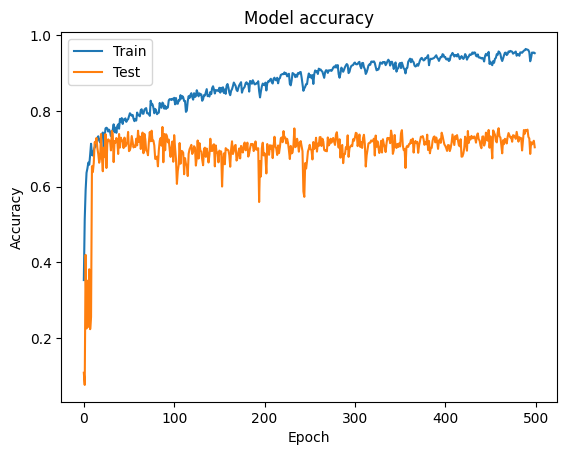

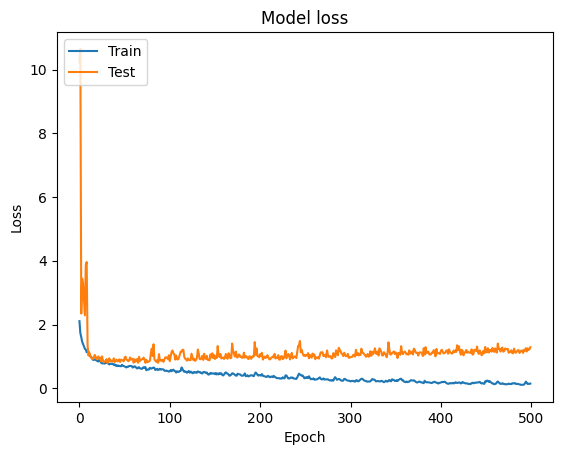

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_03.history['accuracy'])
plt.plot(history_03.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_03.history['loss'])
plt.plot(history_03.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [ ]:
# Save the history to a file
import pickle

with open('train_history_03.pkl', 'wb') as f:
    pickle.dump(history_03.history, f)

In [ ]:

# model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
# callbacks = [
#     keras.callbacks.ModelCheckpoint(filepath='/content/validation_prediction_3year/model_3year_20240415_1835.h5', monitor = 'val_loss', save_best_only=True),
#     save_pred_callback
# ]

In [ ]:

# vguikuytfyu
# def zip_folder(folder_path, output_zip_path):
#     """Zips the contents of a folder into a zip file.

#     Args:
#         folder_path: The path to the folder to be zipped.
#         output_zip_path: The path to the output zip file.
#     """

#     with zipfile.ZipFile(output_zip_path, "w") as zip_file:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 zip_file.write(file_path)

# if __name__ == "__main__":
#     folder_path = "/content/validation_prediction_3year" #Souce folder
#     output_zip_path = "/content/drive/MyDrive/data/working_dir_3year/model_3year_20240415_1835/model_3year_20240415_1835.zip" #zip file

#     zip_folder(folder_path, output_zip_path)

In [ ]:
# import shutil
# import os

# def delete_folder(path):
#     """Deletes a folder at a specified path along with all its contents."""
#     try:
#         shutil.rmtree(path)
#         print(f"Folder '{path}' has been deleted successfully.")
#     except Exception as e:
#         print(f"Failed to delete folder '{path}'. Reason: {e}")

# # Specify the path to the directory you want to delete
# folder_path = '/content/validation_images_THREE'

# # Check if the folder exists then delete
# if os.path.exists(folder_path):
#     delete_folder(folder_path)
# else:
#     print(f"No folder found at {folder_path}")


# using the model to predict


Only thing on here is the predict and save for the final model prediction.

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import rasterio
# from tensorflow.keras.preprocessing.image import array_to_img
# import PIL.ImageOps
# from PIL import Image
# import matplotlib.patches as mpatches
# import matplotlib.colors as mcolors

# class_names = ['Unclassified', 'Water', 'Forested Wetland', 'Emergent Wetland', 'Forested/Shrub Wetland', 'Aquatic Bed', 'Developed', 'Agriculture', 'Grassland', 'Forest', 'Shrubland']
# colors = ['dimgrey', 'cornflowerblue', 'violet', 'teal', 'orange', 'mediumblue', 'lightgrey', 'saddlebrown', 'wheat', 'lightyellow', 'forestgreen', 'peru']
# cmap = mcolors.ListedColormap(colors)


In [44]:
from tensorflow.keras.models import load_model

In [45]:
import pickle
import numpy as np
from tensorflow import keras
from PIL import Image


In [84]:
with open('/content/drive/MyDrive/data/model_prediction/train_history_01.pkl', 'rb') as file:
    train_history_01 = pickle.load(file)
# Optionally, print or inspect the training history
print(train_history_01)

with open('/content/drive/MyDrive/data/model_prediction/train_history_02.pkl', 'rb') as file:
    train_history_02 = pickle.load(file)
# Optionally, print or inspect the training history
print(train_history_02)

with open('/content/drive/MyDrive/data/model_prediction/train_history_03.pkl', 'rb') as file:
    train_history_03 = pickle.load(file)
# Optionally, print or inspect the training history
print(train_history_03)

{'loss': [2.0971269607543945, 1.7173653841018677, 1.615147352218628, 1.5339560508728027, 1.4322527647018433, 1.3536635637283325, 1.3798056840896606, 1.2171586751937866, 1.2008798122406006, 1.1571918725967407, 1.1323155164718628, 1.1723393201828003, 1.0511497259140015, 1.0398459434509277, 1.0174833536148071, 1.0272308588027954, 1.0207470655441284, 1.0109915733337402, 0.9905880689620972, 0.9862515330314636, 0.9368061423301697, 0.9425532221794128, 0.931479811668396, 0.9475786685943604, 0.90816330909729, 0.913088321685791, 0.9092110991477966, 0.900222659111023, 0.9303852915763855, 0.9063087105751038, 0.8841606378555298, 0.8784643411636353, 0.8924882411956787, 0.9287117123603821, 0.8954998850822449, 0.9073764085769653, 0.8844956755638123, 0.8744823932647705, 0.8658005595207214, 0.8771207332611084, 0.8715754151344299, 0.8785858154296875, 0.8884520530700684, 0.8837628960609436, 0.8491647839546204, 0.8433969616889954, 0.8570194840431213, 0.8479186296463013, 0.86100172996521, 0.8451950550079346

In [122]:
model_01 = keras.models.load_model('/content/drive/MyDrive/data/model_prediction/oneyear_data/20240418_1448/20240418_1448.h5')
model_02 = keras.models.load_model('/content/drive/MyDrive/data/model_prediction/twoyear_data/20240418_1448/20240418_1448_2.h5')
model_03 = keras.models.load_model('/content/drive/MyDrive/data/model_prediction/threeyear_data/20240418_1448/20240418_1448_3.h5')

In [123]:
print(x_train_01.shape)
print(x_test_01.shape)

print(x_train_02.shape)
print(x_test_02.shape)

print(x_train_03.shape)
print(x_test_03.shape)

# print(y_train.shape)
# print(y_test.shape)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(105, 384, 384, 5)
(30, 384, 384, 5)
(105, 384, 384, 9)
(30, 384, 384, 9)
(105, 384, 384, 13)
(30, 384, 384, 13)
(105, 384, 384, 7)
(30, 384, 384, 7)


Using the model